# Predcition of Hospital Admission Related to Cough

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to cough. We, then, analyse whether prescribing antibiotics is based on the risk of hospital admission or not by building logistic regression (LR) and random forest (RF) models.

In [1]:
import pandas as pd
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score
import scipy.stats as st
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import logit
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [2]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [3]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [4]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'cough_date_'+str(i), 'cough_ab_date_'+str(i), 'cough_ab_type_'+str(i),
                   'incdt_cough_date_'+str(i), 'admitted_cough_date_'+str(i), 'sgss_gp_cov_cough_date_'+str(i)]]
    
    #drop rows with no cough reord
    datum = datum[datum['cough_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with cough_i
    datum = datum[datum['sgss_gp_cov_cough_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'cough_date_'+str(i): 'cough_date', 'cough_ab_date_'+str(i): 'cough_ab_date', 
                           'cough_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_cough_date_'+str(i): 'incdt_cough_date', 'incdt_cough_type_'+str(i): 'incdt_cough_type',
                           'admitted_cough_date_'+str(i): 'admitted_cough_date',
                           'sgss_gp_cov_cough_date_'+str(i): 'sgss_gp_cov_cough_date'},
                inplace=True)
    
    return datum

In [5]:
#summary table of baseline characteristics
def make_summary_table(infection, infection_type, prob_pred):

    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period']].columns)
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_tot = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit']]], axis=1)

    #calculate sums
    summary_table = prob_pred_enc_tot.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_tot.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_tot.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [6]:
#summary table of baseline characteristics
def make_summary_table_deciles(infection, infection_type, prob_pred_enc_lr_rf):
    #calculate sums
    summary_table = prob_pred_enc_lr_rf.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_lr_rf.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_lr_rf.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_deciles_'+infection+'_'+infection_type+'.csv', index=False)

In [7]:
def cox_build(infection, infection_type, data, data_no_abs):
    #randomly splitting data into training (%75) and testing (%25)
    data_dev, data_val = train_test_split(data_no_abs, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_dev,
            duration_col='duration_cough_admitted',
            event_col='event_cough_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    ##add deciles of predicted risks and probability of prescribed antibiotics
    #predict cumulative hazard in day 30 in train dataset
    prob_pred = cph.predict_cumulative_hazard(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'antibacterial_brit']]).loc[[30]].T
    prob_pred.columns = ['pred']
    #prob_pred_cough_no_abs_incdt

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred['bins'] = pd.qcut(prob_pred['pred'], 10)
    #prob_pred

    ##add a columns of risk factors, prescribed antibiotics, and hosp event 
    prob_pred = pd.concat([prob_pred, data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'antibacterial_brit', 'ab_binary', 'event_'+infection+'_admitted']]], axis=1)
    #prob_pred

    ###needed for figures
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_bin = prob_pred.groupby('bins')[['pred', 'ab_binary', 'event_'+infection+'_admitted']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_prob_mean', 'ab_prob_sum', 'ab_prob_count', 'event_'+infection+'_admitted_mean', 'event_'+infection+'_admitted_sum', 'event_'+infection+'_admitted_count']
    prob_pred_bin['bins'] = prob_pred_bin['bins'].astype(str)
    #prob_pred_urti_no_abs_incdt_bin
    prob_pred_bin.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_bin_'+infection+'_'+infection_type+'.csv', index=False)

    #plot
    plt.figure(figsize=(10,7))
    sns.lineplot(x='bins', y='ab_prob_mean', data=prob_pred_bin, marker='o', markersize=10)
    g = sns.lineplot(x="bins", data=prob_pred_bin, y="ab_prob_mean", marker='*', linestyle='--', markersize=10)
    plt.ylim(0)#, data.pred_mean_train.max() + data.pred_mean_train.max()/3)
    plt.xlim(0)#, data.ab_prob_mean_train.max() + data.ab_prob_mean_train.max()/3)
    plt.setp(g.collections, alpha=.5) #alpha for markers
    plt.setp(g.lines, alpha=.5) #alpha for line
    plt.xlabel('Decile', fontsize=14)
    plt.ylabel('Mean probability of prescribing antibiotic', fontsize=14)
    plt.gca().set_xticks(np.arange(0,10,1), minor=True)
    plt.grid(b=True, which='major', color='k', linestyle=':', alpha=0.5)
    plt.grid(which='minor', color='k', linestyle=':', alpha=0.5)
    plt.xticks(prob_pred_bin.bins, rotation=90)
    # plt.legend([],[], frameon=False)
    # plt.savefig('../output/aggregate_ab_prob/aggregate_ab_prob_incdt.jpg')
    plt.show()

    return prob_pred, prob_pred_bin

In [8]:
def lr_rf_build_risk_deciles(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)

    #save prob_pred for analysis in r
    prob_pred.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_lr_rf_'+infection+'_'+infection_type+'_r_analysis.csv', index=False)

    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['bins']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['bins']].columns)
    #drop 1st column to take it as reference group
    prob_pred_enc = prob_pred_enc.iloc[: , 1:]
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['ab_binary']]], axis=1)
    #prob_pred_enc_lr_rf

    #save prob_pred_enc_lr_rf for analysis in r
    prob_pred_enc_lr_rf.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_lr_rf_'+infection+'_'+infection_type+'_r_analysis_binned.csv', index=False)

    ##rf, lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr_rf, test_size=0.25)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    #building lr model
    lr = LogisticRegression(solver="saga", random_state=42).fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict_proba(data_enc_dev_x)[:,1]
    lr_pred_val = lr.predict_proba(data_enc_val_x)[:,1]

    # ##building rf model
    # rf = RandomForestClassifier()#n_estimators=500, max_leaf_nodes=50, max_depth=50)
    # rf.fit(data_enc_dev_x, data_enc_dev_y)
    # #predict probabilities to rf model
    # rf_pred_dev = rf.predict_proba(data_enc_dev_x)[:,1]
    # rf_pred_val = rf.predict_proba(data_enc_val_x)[:,1]

    #calculate aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    # auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    # auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    #save and print aurocs
    auroc_lr = pd.DataFrame([[auroc_lr_dev, auroc_lr_val]], columns=['auroc_dev', 'auroc_val'])
    auroc_lr.to_csv('../output/hospitalisation_prediction_'+infection+'/auroc_lr_'+infection+'_'+infection_type+'.csv')
    print('\nAUROC of LR for deciles with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    # print('AUROC of RF for deciles with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    #caculate ORs and intervals of LR model, save and print them 
    # lr_coef = pd.DataFrame({"or": lr.coef_})#, "Lower CI": lr.conf_int()[0], "Upper CI": lr.conf_int()[1],})
    # lr_coef_exp = np.exp(lr_coef)
    # lr_coef_exp.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_deciles_'+infection+'_'+infection_type+'.csv')
    # lr_coef = lr.coef_
    # print('LR ORs:\n %s'%(lr_coef))
    # lr_coef = pd.DataFrame(data=np.exp(lr.coef_), index=data_enc_dev_x.columns, columns=['lr_coef'])
    # lr_coef = lr_coef.sort_values('lr_coef', ascending=False)
    # lr_coef = pd.DataFrame(data=lr.coef_.T, index=data_enc_dev_x.columns, columns=['lr_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    # # lr_coef['lr_coef_lower_bound'] = st.norm.ppf(lr_coef['lr_coef'])
    
    # alpha = 0.05
    # #the coefficients of the regression model
    # coefs = np.r_[lr.coef_.T.tolist()]#[lr.intercept_], lr.coef_.T.tolist()
    # #build an auxiliary dataframe with the constant term in it
    # X_aux = data_enc_dev_x.copy()
    # # X_aux.insert(0, 'const', 1)
    # #degrees of freedom
    # dof = -np.diff(X_aux.shape)[0]
    # #Student's t-distribution table lookup
    # t_val = stats.t.isf(alpha/2, dof)
    # #MSE of the residuals
    # mse = np.sum((data_enc_dev_y['ab_binary'].to_numpy() - lr.predict(data_enc_dev_x)) ** 2) / dof
    # #inverse of the variance of the parameters
    # var_params = np.diag(np.linalg.inv(X_aux.T.dot(X_aux)))
    # #distance between lower and upper bound of CI
    # gap = t_val * np.sqrt(mse * var_params)
    # lr_coef_ors_ints = pd.DataFrame({'coef': coefs.ravel(), 'coef_lower': coefs.ravel() - gap, 'coef_upper': coefs.ravel() + gap}, index=X_aux.columns)
    # lr_coef_ors_ints[['ors', 'ors_lower', 'ors_upper']] = np.exp(lr_coef_ors_ints[['coef', 'coef_lower', 'coef_upper']])
    # # lr_coef_ors_ints = lr_coef_ors_ints.sort_values('coef', ascending=False)
    # lr_coef_ors_ints.to_csv('../output/hospitalisation_prediction_'+infection+'/ors_lr_'+infection+'_'+infection_type+'.csv')
    lr_summary = get_lr_betas_intervals(data_enc_dev)
    lr_summary.to_csv('../output/hospitalisation_prediction_'+infection+'/ors_lr_'+infection+'_'+infection_type+'.csv')
    print('LR summary:\n %s'%(lr_summary))

    #print parameters of grid search
    # print("\nRF parameters after grid search:", rf)

    # #print feature importance of RF model
    # rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_enc_dev_x.columns, columns=['rf_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    # rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    # rf_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_deciles_'+infection+'_'+infection_type+'.csv')
    # print('\nRF feature importance:\n %s'%(rf_coef))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    # r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    # r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    # line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    # line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR model with deciles", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_deciles_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr_rf, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val#, rf_pred_dev, rf_pred_val

In [9]:
def lr_rf_build_risk_riskfactors(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)
    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season']].columns)
    #drop ref columns
    prob_pred_enc = prob_pred_enc[['age_cat_25_34', 'age_cat_35_44', 'age_cat_45_54', 'age_cat_55_64', 'age_cat_65_74', 'age_cat_75_more', #'age_cat_15_24', 
                                   'sex_male', #'sex_female', 
                                   'CCI_cat_high', 'CCI_cat_low', 'CCI_cat_medium', 'CCI_cat_very_high', #'CCI_cat_very_low', 
                                   'flu_vaccine_yes', #'flu_vaccine_no',
                                   'bmi_cat_obese', 'bmi_cat_overweight', 'bmi_cat_underweight', 'bmi_cat_unknown', #'bmi_cat_healthy_weight',
                                   'region_yorkshire', 'region_east_midlands', 'region_london', 'region_north_east', 'region_north_west', 'region_south_east', 'region_south_west', 'region_west_midlands', #'region_east', 
                                   'imd_very_unaffluent', 'imd_medium', 'imd_affluent', 'imd_very_affluent', 'imd_unknown', #'imd_unaffluent',
                                   'ethnicity_asian', 'ethnicity_other', 'ethnicity_unknown', 'ethnicity_mixed', 'ethnicity_black', #'ethnicity_white', 
                                   'smoking_smoker', 'smoking_never_smoked', 'smoking_unknown', #'smoking_ex_smoker', 
                                   'season_spring', 'season_summer', 'season_winter', #'season_autumn',
                                   ]]
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit', 'ab_binary']]], axis=1)
    #prob_pred_enc_lr_rf

    ##rf, lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr_rf, test_size=0.25)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    #building lr model
    lr = LogisticRegression(solver="saga", random_state=42).fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict_proba(data_enc_dev_x)[:,1]
    lr_pred_val = lr.predict_proba(data_enc_val_x)[:,1]

    # ##building rf model
    # rf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=50, max_depth=50)
    # rf.fit(data_enc_dev_x, data_enc_dev_y)
    # #predict probabilities to rf model
    # rf_pred_dev = rf.predict_proba(data_enc_dev_x)[:,1]
    # rf_pred_val = rf.predict_proba(data_enc_val_x)[:,1]

    #print aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    # auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    # auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    print('\nAUROC of LR for risk factors with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    # print('AUROC of RF for risk factors with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    # #print summary of LR model
    # lr_coef = pd.DataFrame({"OR": lr.params, "Lower CI": lr.conf_int()[0], "Upper CI": lr.conf_int()[1],})
    # lr_coef = np.exp(lr_coef)
    # lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_'+infection+'_'+infection_type+'.csv')
    # print('LR coefficients:\n %s'%(lr_coef))
   
   #  alpha = 0.05
   #  #the coefficients of the regression model
   #  coefs = np.r_[lr.coef_.T.tolist()] #[lr.intercept_], lr.coef_.T.tolist()
   #  #build an auxiliary dataframe with the constant term in it
   #  X_aux = data_enc_dev_x.copy()
   # #  X_aux.insert(0, 'const', 1)
   #  #degrees of freedom
   #  dof = -np.diff(X_aux.shape)[0]
   #  #Student's t-distribution table lookup
   #  t_val = stats.t.isf(alpha/2, dof)
   #  #MSE of the residuals
   #  mse = np.sum((data_enc_dev_y['ab_binary'].to_numpy() - lr.predict(data_enc_dev_x)) ** 2) / dof
   #  #inverse of the variance of the parameters
   #  var_params = np.diag(np.linalg.inv(X_aux.T.dot(X_aux)))
   #  #distance between lower and upper bound of CI
   #  gap = t_val * np.sqrt(mse * var_params)
   #  lr_coef_ors_ints = pd.DataFrame({'coef': coefs.ravel(), 'coef_lower': coefs.ravel() - gap, 'coef_upper': coefs.ravel() + gap}, index=X_aux.columns)
   #  lr_coef_ors_ints[['ors', 'ors_lower', 'ors_upper']] = np.exp(lr_coef_ors_ints[['coef', 'coef_lower', 'coef_upper']])
   #  # lr_coef_ors_ints = lr_coef_ors_ints.sort_values('coef', ascending=False)
   #  lr_coef_ors_ints.to_csv('../output/hospitalisation_prediction_'+infection+'/ors_lr_'+infection+'_'+infection_type+'.csv')
    lr_summary = get_lr_betas_intervals(data_enc_dev)
    lr_summary.to_csv('../output/hospitalisation_prediction_'+infection+'/ors_lr_'+infection+'_'+infection_type+'.csv')
    print('LR summary:\n %s'%(lr_summary))

    #print parameters of grid search
    # print("\nRF parameters after grid search:", rf)

    # #print feature importance of RF model
    # rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_enc_dev_x.columns, columns=['rf_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    # rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    # lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_'+infection+'_'+infection_type+'.csv')
    # print('\nRF feature importance:\n %s'%(rf_coef))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    # r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    # r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    # line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    # line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR and RF models with risk factors", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_riskfactors_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr_rf, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val#, rf_pred_dev, rf_pred_val

In [10]:
#bootstrap and create lr models
def lr_bootstrap(data):
    sample = data.sample(data.shape[0], replace=True)
    X_tr = sample[[c for c in sample.columns if c != 'ab_binary']]
    y_tr = sample.ab_binary
    lr = LogisticRegression().fit(X_tr, y_tr)
    params = list(lr.coef_[0]) 

    return params

In [11]:
#calculate mean and standard error of lr models with bootstraped data to calculate mean coeffients and intervals of coefficients and odds ratios and their intervals
def get_lr_betas_intervals(data):
    #get column names of inputs
    data_x_columns = data.drop('ab_binary', axis=1).columns
    #create lr models with bootstraped samples for 100 times
    params_samples = pd.DataFrame([lr_bootstrap(data) for _ in range(100)])
    #calculate mean and standard error for coefficients of lrs with samples
    coefs_mean = params_samples.mean()
    coefs_se = params_samples.std()
    z_val = stats.norm.ppf(0.975)
    coefs_se_z_val = coefs_se * z_val
    #create a table of coefficients and their intervals for covariates 
    lr_summary = pd.DataFrame({'covariate': data_x_columns.tolist(), 'coef': coefs_mean, 'coef_lower_95%': coefs_mean - coefs_se_z_val, 'coef_upper_95%': coefs_mean + coefs_se_z_val})
    #clculate odds ratios and their intervals for covariates
    lr_summary[['or', 'or_lower_95%', 'or_upper_95%']] = np.exp(lr_summary[['coef', 'coef_lower_95%', 'coef_upper_95%']])

    return lr_summary

In [12]:
def calibration_rf_lr(infection, infection_type, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val):#, rf_pred_dev, rf_pred_val):
    # ##calibration for RF
    # rf_prob_pred_dev = pd.DataFrame(data=rf_pred_dev, columns=['pred'])
    # #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    # rf_prob_pred_dev['bins'] = pd.qcut(rf_prob_pred_dev['pred'], 10, duplicates="drop")
    # #merge cumulative hazards with their actual events (0, 1)
    # rf_prob_pred_dev = pd.merge(rf_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    # #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    # rf_prob_pred_dev_groupby_bin = rf_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    # rf_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    # #calculate proportion of events in each bin
    # rf_prob_pred_dev_groupby_bin['ab_binary_proportion'] = rf_prob_pred_dev_groupby_bin['ab_binary_sum']/rf_prob_pred_dev_groupby_bin['ab_binary_count']
    # #
    # rf_prob_pred_val = pd.DataFrame(data=rf_pred_val, columns=['pred'])
    # #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    # rf_prob_pred_val['bins'] = pd.qcut(rf_prob_pred_val['pred'], 10, duplicates="drop")
    # #merge cumulative hazards with their actual events (0, 1)
    # rf_prob_pred_val = pd.merge(rf_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    # #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    # rf_prob_pred_val_groupby_bin = rf_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    # rf_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    # #calculate proportion of events in each bin
    # rf_prob_pred_val_groupby_bin['ab_binary_proportion'] = rf_prob_pred_val_groupby_bin['ab_binary_sum']/rf_prob_pred_val_groupby_bin['ab_binary_count']
    # #plot calibration plot for RF model with development and validation data
    # fig, ax1 = plt.subplots(figsize=(7, 7))
    # plt.plot(rf_prob_pred_dev_groupby_bin.pred_mean, rf_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#8D576D', linestyle='solid', marker='o', alpha=0.9)
    # plt.plot(rf_prob_pred_val_groupby_bin.pred_mean, rf_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#eb91b7', linestyle='dashed', marker='v', alpha=0.9)
    # plt.xlabel('Mean predicted probabilities', fontsize=14)
    # plt.ylabel('Proportion of observed values', fontsize=14)
    # plt.xticks(fontsize=12)
    # plt.yticks(fontsize=12, rotation=0)
    # plt.xlim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    # plt.ylim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    # plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    # plt.title("Calibration plot of RF model", fontsize=14)
    # legend_dev = mlines.Line2D([], [], color='#8D576D', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    # legend_val = mlines.Line2D([], [], color='#eb91b7', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.9)
    # plt.legend(handles=[legend_dev, legend_val])
    # plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_rf_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    # plt.show()

    ##calibration for LR
    lr_prob_pred_dev = pd.DataFrame(data=lr_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_dev['bins'] = pd.qcut(lr_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_dev = pd.merge(lr_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_dev_groupby_bin = lr_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_dev_groupby_bin['ab_binary_proportion'] = lr_prob_pred_dev_groupby_bin['ab_binary_sum']/lr_prob_pred_dev_groupby_bin['ab_binary_count']
    #
    lr_prob_pred_val = pd.DataFrame(data=lr_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_val['bins'] = pd.qcut(lr_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_val = pd.merge(lr_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_val_groupby_bin = lr_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_val_groupby_bin['ab_binary_proportion'] = lr_prob_pred_val_groupby_bin['ab_binary_sum']/lr_prob_pred_val_groupby_bin['ab_binary_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(lr_prob_pred_dev_groupby_bin.pred_mean, lr_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#408678', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(lr_prob_pred_val_groupby_bin.pred_mean, lr_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#6ce0c9', linestyle='dashed', marker='v', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of LR model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#408678', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#6ce0c9', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.6)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_lr_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

## 1- data preparation

In [13]:
#read data
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_cough.csv.gz')

In [14]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [15]:
#process 20 coughs and concatenate them 
data_cough_1 = proc_infec_data(data,1)
data_cough_2 = proc_infec_data(data,2)
data_cough_3 = proc_infec_data(data,3)
data_cough_4 = proc_infec_data(data,4)
data_cough_5 = proc_infec_data(data,5)
data_cough_6 = proc_infec_data(data,6)
data_cough_7 = proc_infec_data(data,7)
data_cough_8 = proc_infec_data(data,8)
data_cough_9 = proc_infec_data(data,9)
data_cough_10 = proc_infec_data(data,10)
data_cough_11 = proc_infec_data(data,11)
data_cough_12 = proc_infec_data(data,12)
data_cough_13 = proc_infec_data(data,13)
data_cough_14 = proc_infec_data(data,14)
data_cough_15 = proc_infec_data(data,15)
data_cough_16 = proc_infec_data(data,16)
data_cough_17 = proc_infec_data(data,17)
data_cough_18 = proc_infec_data(data,18)
data_cough_19 = proc_infec_data(data,19)
data_cough_20 = proc_infec_data(data,20)

data_cough = pd.concat([data_cough_1, data_cough_2, data_cough_3, data_cough_4, data_cough_5, data_cough_6, data_cough_7, data_cough_8, data_cough_9, data_cough_10, data_cough_11, data_cough_12, data_cough_13, data_cough_14, data_cough_15, data_cough_16, data_cough_17, data_cough_18, data_cough_19, data_cough_20])
data_cough.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [16]:
##add variable season
#convert data types
data_cough['cough_date'] = data_cough['cough_date'].astype('datetime64[ns]')
data_cough['admitted_cough_date'] = data_cough['admitted_cough_date'].astype('datetime64[ns]')
data_cough.died_date = data_cough.died_date.astype('datetime64[ns]')
data_cough.deregistered_date = data_cough.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_cough['date'] = data_cough['cough_date'] 
data_cough['date'] = data_cough['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_cough with today's date in year and month
data_cough = data_cough[data_cough['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_cough = data_cough[data_cough['date'] != last_1_month_date_y_m]
data_cough = data_cough[data_cough['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of cough records
data_cough['season'] = np.nan
data_cough['date_month'] = pd.DatetimeIndex(data_cough['date']).month

conditions = [
    (data_cough['date_month'] >= 3) & (data_cough['date_month'] <= 5),
    (data_cough['date_month'] >= 6) & (data_cough['date_month'] <= 8),
    (data_cough['date_month'] >= 9) & (data_cough['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_cough['season'] = np.select(conditions, choices, default='winter')

In [17]:
#add variable time period
data_cough.loc[(data_cough['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_cough.loc[((data_cough['date'] >= '2020-05') & (data_cough['date'] <= '2021-04')), 'period'] = 'during_pandemic'
data_cough.loc[(data_cough['date'] >= '2021-05'), 'period'] = 'post_2nd_lockdown'

#drop any row with nan in period column
data_cough = data_cough[data_cough['period'].notna()]

In [18]:
data_cough['date'].max()

'2023-05'

#### event and duration

In [19]:
#scenario 1
#not hosped (nothing happened)
data_cough.loc[data_cough['admitted_cough_date'].isnull(), 'event_cough_admitted'] = 0

In [20]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_cough['delta_cough_admitted'] = (data_cough['admitted_cough_date'] - data_cough['cough_date']).dt.days
data_cough.loc[((data_cough['delta_cough_admitted'] >= 0) & (data_cough['delta_cough_admitted'] <= 30)), 'event_cough_admitted'] = 1

#scenario 2
#drop whoever was admitted before cough consultation, i.e. negative value for delta_cough_admitted
data_cough = data_cough[~(data_cough['delta_cough_admitted'] < 0)]

In [21]:
#scenario 3
#censor died patients
data_cough['delta_admitted_died'] = (data_cough['died_date'] - data_cough['admitted_cough_date']).dt.days
data_cough.loc[data_cough['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_cough.loc[((data_cough['delta_admitted_died'] >= 0) & (data_cough['delta_admitted_died'] <= 30)), 'event_cough_admitted'] = 0

#scenario 3
#censor deregistered patients
data_cough['delta_admitted_deregistered'] = (data_cough['deregistered_date'] - data_cough['admitted_cough_date']).dt.days
data_cough.loc[data_cough['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_cough.loc[((data_cough['delta_admitted_deregistered'] > 0) & (data_cough['delta_admitted_deregistered'] <= 30)), 'event_cough_admitted'] = 0

#agg scenario 3s
data_cough['delta_admitted_died_deregistered'] = data_cough['delta_admitted_deregistered'].combine_first(data_cough['delta_admitted_died'])
data_cough.loc[data_cough['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [22]:
#scenario 1
#any other patients (nothing happened)
data_cough['event_cough_admitted'] = data_cough['event_cough_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_cough['duration_cough_admitted'] = data_cough['delta_cough_admitted'].combine_first(data_cough['delta_admitted_died_deregistered'])
data_cough['duration_cough_admitted'] = data_cough['duration_cough_admitted'].replace(np.NaN, 30)
data_cough.loc[(data_cough['duration_cough_admitted'] > 30), 'duration_cough_admitted'] = 30

#give value 1 to event_cough_admitted if duration_cough_admitted is greater or equal to 0 and less than 30
data_cough.loc[((data_cough['duration_cough_admitted'] >= 0) & (data_cough['duration_cough_admitted'] < 30)), 'event_cough_admitted'] = 1

#drop any rows with value 0 in duration column
data_cough = data_cough[~(data_cough['duration_cough_admitted'] == 0)]

In [23]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_cough.loc[((data_cough['delta_cough_admitted'] > 0) & (data_cough['delta_cough_admitted'] < 30)), 'event_cough_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [24]:
#drop anybody with age less than 18 or 0!
data_cough = data_cough[~(data_cough['age'] < 18)] 
data_cough['age'][data_cough['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_cough = data_cough[data_cough['age_cat'] != '0-4']
data_cough = data_cough[data_cough['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_cough['bmi'][data_cough['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_cough['bmi'] = data_cough['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_cough['antibacterial_brit'][data_cough['antibacterial_brit'] < 0] = np.nan

In [25]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_cough = data_cough.replace({"sex": dict_sex})
data_cough = data_cough.replace({"smoking": dict_smoking})

In [26]:
#drop rows with missing region
if ('region' in data_cough.columns) and (data_cough['region'].isnull().sum() > 0):
   data_cough = data_cough[data_cough['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_cough.columns) and (data_cough['antibacterial_brit'].isnull().sum() > 0):
    data_cough['antibacterial_brit'] = data_cough['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_cough.columns) and (data_cough['ethnicity'].isnull().sum() > 0):
    data_cough['ethnicity'] = data_cough['ethnicity'].fillna(0)

#replace rows with missing smoking with 0
if ('smoking' in data_cough.columns) and (data_cough['smoking'].isnull().sum() > 0):
    data_cough['smoking'] = data_cough['smoking'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_cough.columns) and (data_cough['imd'].isnull().sum() > 0):
    data_cough['imd'] = data_cough['imd'].fillna(0)

In [27]:
#missing values of bmi assign 5 and 0; categorise bmi
data_cough['bmi_cat'] = 5

for idx, x in enumerate(data_cough['bmi_cat']):
    if data_cough.iat[idx, data_cough.columns.get_loc('bmi')] >= 30:
        data_cough.iat[idx, data_cough.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_cough.iat[idx, data_cough.columns.get_loc('bmi')] >= 25) and (data_cough.iat[idx, data_cough.columns.get_loc('bmi')] < 30):
        data_cough.iat[idx, data_cough.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_cough.iat[idx, data_cough.columns.get_loc('bmi')] >= 18.5) and (data_cough.iat[idx, data_cough.columns.get_loc('bmi')] < 25):
        data_cough.iat[idx, data_cough.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_cough.iat[idx, data_cough.columns.get_loc('bmi')] < 18.5:
        data_cough.iat[idx, data_cough.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_cough.columns) and (data_cough['bmi_cat'].isnull().sum() > 0):
    data_cough['bmi_cat'] = data_cough['bmi_cat'].fillna(0)

In [28]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_cough.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_cough['ab_type_cat'] = np.where(data_cough['ab_type'].isin(ab_series[mask].index),'other',data_cough['ab_type'])
#assign no to non ab users
data_cough.loc[data_cough['cough_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_cough['ab_type_cat'] = data_cough['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [29]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'mixed', 3.0: 'asian', 4.0: 'black', 5.0: 'other', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_cough = data_cough.replace({"sex": dict_sex})
data_cough = data_cough.replace({"ethnicity": dict_ethnicity})
data_cough = data_cough.replace({"smoking": dict_smoking})
data_cough = data_cough.replace({"imd": dict_imd})
data_cough = data_cough.replace({"bmi_cat": dict_bmi})
data_cough = data_cough.replace({"flu_vaccine": dict_flu})
data_cough = data_cough.replace({"region": dict_region})
data_cough = data_cough.replace({"age_cat": dict_age})
data_cough = data_cough.replace({"ab_type_cat": dict_ab_type})

In [30]:
data_cough.ethnicity.value_counts('NA')

white      0.601751
unknown    0.249843
asian      0.074729
other      0.073677
Name: ethnicity, dtype: float64

In [31]:
data_cough.smoking.value_counts('NA')

unknown         0.414755
smoker          0.390141
never_smoked    0.129576
ex_smoker       0.065527
Name: smoking_status, dtype: float64

In [32]:
data_cough.bmi_cat.value_counts('NA')

obese             0.518061
unknown           0.255000
overweight        0.111988
healthy_weight    0.082293
underweight       0.032657
Name: bmi_cat, dtype: float64

### 2-5- categorising and assigning max value for continuous variables

In [33]:
#categorise CCI
data_cough['CCI_cat'] = pd.cut(data_cough['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_cough['antibacterial_brit'].clip(0, data_cough['antibacterial_brit'].quantile(0.95), inplace=True)

## 3- plots

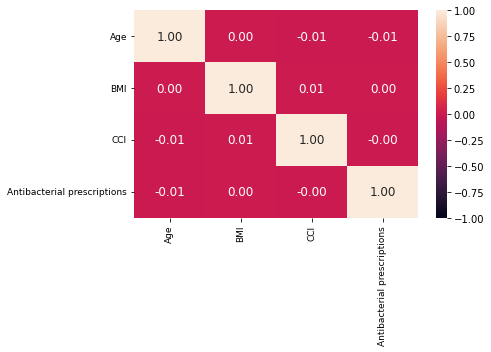

In [34]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_cough[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_cough/corr_cough.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [35]:
data_cough = data_cough[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 
                                   'antibacterial_brit', 'cough_ab_date', 'ab_type_cat', 'incdt_cough_date', 'date', 'period',
                                   'event_cough_admitted', 'duration_cough_admitted'
                                    ]]

In [36]:
#switch variable cough_ab_date into a binary variable
data_cough[['ab_binary']] = data_cough[['cough_ab_date']].where(data_cough[['cough_ab_date']].isnull(), 1).fillna(0).astype(int)
#incident and prevalent infection 
data_cough_incdt = data_cough[data_cough['incdt_cough_date'] == 0]
data_cough_prevl = data_cough[data_cough['incdt_cough_date'] == 1]

#no antibiotics and incident hospital admission
data_cough_no_abs_incdt = data_cough_incdt[data_cough_incdt['ab_binary'] == 0]
#with antibiotics and incident hospital admission
data_cough_abs_incdt = data_cough_incdt[data_cough_incdt['ab_binary'] == 1]

#no antibiotics and prevalent hospital admission
data_cough_no_abs_prevl = data_cough_prevl[data_cough_prevl['ab_binary'] == 0]
#with antibiotics and prevalent hospital admission
data_cough_abs_prevl = data_cough_prevl[data_cough_prevl['ab_binary'] == 1]

In [37]:
##subcohorts for stratification by period
#incident and prevalent infection stratified by time period categories
data_cough_incdt_prepandemic = data_cough_incdt[data_cough_incdt['period'] == 'prepandemic']
data_cough_incdt_during_pandemic = data_cough_incdt[(data_cough_incdt['period'] == 'during_pandemic')]
data_cough_incdt_post_2nd_lockdown = data_cough_incdt[data_cough_incdt['period'] == 'post_2nd_lockdown']
data_cough_prevl_prepandemic = data_cough_prevl[data_cough_prevl['period'] == 'prepandemic']
data_cough_prevl_during_pandemic = data_cough_prevl[(data_cough_prevl['period'] == 'during_pandemic')]
data_cough_prevl_post_2nd_lockdown = data_cough_prevl[data_cough_prevl['period'] == 'post_2nd_lockdown']

#no antibiotics and incident hospital admission
data_cough_no_abs_incdt_prepandemic = data_cough_incdt_prepandemic[data_cough_incdt_prepandemic['ab_binary'] == 0]
data_cough_no_abs_incdt_during_pandemic = data_cough_incdt_during_pandemic[data_cough_incdt_during_pandemic['ab_binary'] == 0]
data_cough_no_abs_incdt_post_2nd_lockdown = data_cough_incdt_post_2nd_lockdown[data_cough_incdt_post_2nd_lockdown['ab_binary'] == 0]
data_cough_no_abs_prevl_prepandemic = data_cough_prevl_prepandemic[data_cough_prevl_prepandemic['ab_binary'] == 0]
data_cough_no_abs_prevl_during_pandemic = data_cough_prevl_during_pandemic[data_cough_prevl_during_pandemic['ab_binary'] == 0]
data_cough_no_abs_prevl_post_2nd_lockdown = data_cough_prevl_post_2nd_lockdown[data_cough_prevl_post_2nd_lockdown['ab_binary'] == 0]

In [38]:
#store data for plotting hosp admission counts and percentages
%store data_cough
# save data
data_cough.to_csv('../output/hospitalisation_prediction_cough/data_cough.csv')

Stored 'data_cough' (DataFrame)


## 5- modelling of antibiotics prediction based on risk of hospital admission
### 5-0- summary tables

In [39]:
#make summary tables
make_summary_table('cough', 'no_abs_incdt', data_cough_no_abs_incdt)
make_summary_table('cough', 'abs_incdt', data_cough_abs_incdt)
make_summary_table('cough', 'no_abs_prevl', data_cough_no_abs_prevl)
make_summary_table('cough', 'abs_prevl', data_cough_abs_prevl)

### 5-1- incident

<lifelines.CoxPHFitter: fitted with 102743 total observations, 102064 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 102743
number of events observed = 679
   partial log-likelihood = -7816.59
         time fit was run = 2023-08-04 16:22:53 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.05       1.05       0.12            -0.18             0.27                 0.84                 1.31
CCI_cat[T.medium]                0.03       1.03       0.13            -0.22             0.28                 0.80                 1.32
CCI_cat[T.high]                 -0.02       0.98       0.15            -0.32             0.29                 0.73                 1.33
CCI_cat[T.very_high]             0.07       1.08       0.13            -0.19             0.33                 0.83                 1.40
age_cat[T.25_34]                -0.12       0.88       0.15            -0.41             0.16                 0.66                 1.17
age_cat[T.35_44]                 0.07       1.07       0.14            -0.20             0.34                 0.82                 1.41
age_cat[T.45_54]                 0.02       1.02       0.14            -0.26             0.29                 0.77                 1.34
age_cat[T.55_64]                -0.16       0.85       0.15            -0.45             0.12                 0.64                 1.13
age_cat[T.65_74]                -0.06       0.94       0.14            -0.34             0.22                 0.71                 1.25
age_cat[T.75_more]              -0.01       0.99       0.14            -0.29             0.27                 0.75                 1.31
antibacterial_brit              -0.02       0.98       0.03            -0.07             0.04                 0.93                 1.04
bmi_cat[T.obese]                 0.04       1.04       0.14            -0.24             0.32                 0.79                 1.38
bmi_cat[T.overweight]           -0.06       0.94       0.18            -0.41             0.29                 0.66                 1.33
bmi_cat[T.underweight]          -0.30       0.74       0.28            -0.84             0.25                 0.43                 1.28
bmi_cat[T.unknown]              -0.05       0.95       0.15            -0.36             0.25                 0.70                 1.28
ethnicity[T.other]               0.34       1.40       0.20            -0.07             0.74                 0.94                 2.09
ethnicity[T.unknown]             0.10       1.10       0.18            -0.25             0.44                 0.78                 1.55
ethnicity[T.white]               0.26       1.30       0.16            -0.06             0.58                 0.94                 1.79
flu_vaccine[T.yes]              -0.02       0.98       0.13            -0.27             0.24                 0.76                 1.26
imd[T.medium]                    0.10       1.11       0.13            -0.14             0.35                 0.87                 1.42
imd[T.unaffluent]               -0.01       0.99       0.13            -0.26             0.24                 0.77                 1.28
imd[T.unknown]                   0.21       1.23       0.19            -0.15             0.58                 0.86                 1.78
imd[T.very_affluent]             0.16       1.17       0.12            -0.09             0.40                 0.92                 1.49
imd[T.very_unaffluent]           0.06       1.07       0.13            -0.19             0.31                 0.83                 1.37
region[T.east_midlands]         -0.26       0.77       0.17    

13050


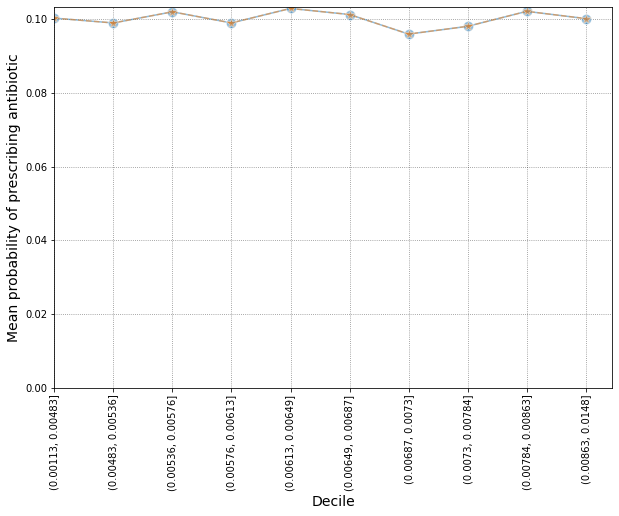


AUROC of LR for deciles with development and validation data: 0.50641 and 0.50294
LR summary:
                  covariate      coef  coef_lower_95%  coef_upper_95%  \
0  bins_(0.00483, 0.00536]  0.005441       -0.084074        0.094956   
1  bins_(0.00536, 0.00576]  0.029426       -0.068402        0.127255   
2  bins_(0.00576, 0.00613] -0.032858       -0.118355        0.052640   
3  bins_(0.00613, 0.00649]  0.029315       -0.059787        0.118417   
4  bins_(0.00649, 0.00687] -0.000318       -0.096543        0.095908   
5   bins_(0.00687, 0.0073] -0.040479       -0.125456        0.044498   
6   bins_(0.0073, 0.00784] -0.010574       -0.102810        0.081662   
7  bins_(0.00784, 0.00863]  0.030622       -0.065001        0.126246   
8   bins_(0.00863, 0.0148]  0.001878       -0.091804        0.095560   

         or  or_lower_95%  or_upper_95%  
0  1.005455      0.919363      1.099610  
1  1.029864      0.933885      1.135707  
2  0.967676      0.888381      1.054050  
3  1.029749    

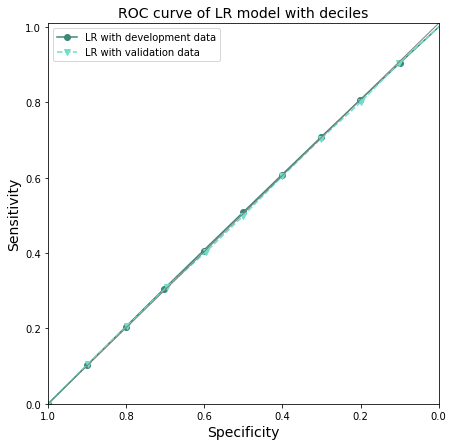

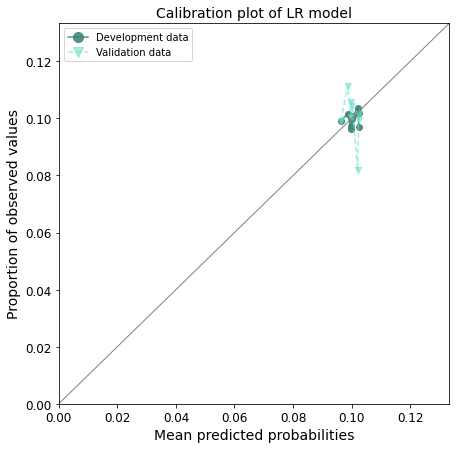


AUROC of LR for risk factors with development and validation data: 0.51891 and 0.49817
LR summary:
                       covariate      coef  coef_lower_95%  coef_upper_95%  \
0                 age_cat_25_34 -0.041500       -0.115226        0.032226   
1                 age_cat_35_44  0.013411       -0.060157        0.086979   
2                 age_cat_45_54 -0.029199       -0.100262        0.041864   
3                 age_cat_55_64 -0.040088       -0.121841        0.041665   
4                 age_cat_65_74 -0.024066       -0.093401        0.045270   
5               age_cat_75_more  0.013945       -0.066069        0.093960   
6                      sex_male -0.004567       -0.047044        0.037911   
7                  CCI_cat_high -0.076325       -0.152207       -0.000442   
8                   CCI_cat_low -0.094586       -0.141978       -0.047194   
9                CCI_cat_medium -0.045147       -0.105174        0.014880   
10            CCI_cat_very_high -0.062066       -0.1

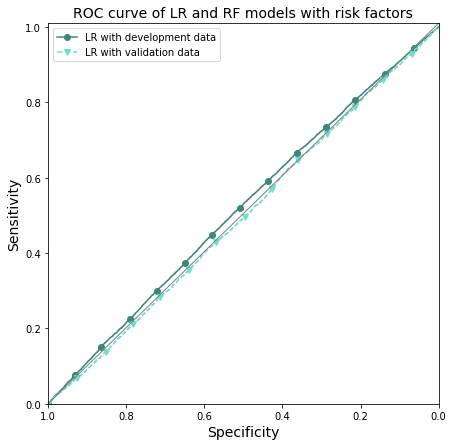

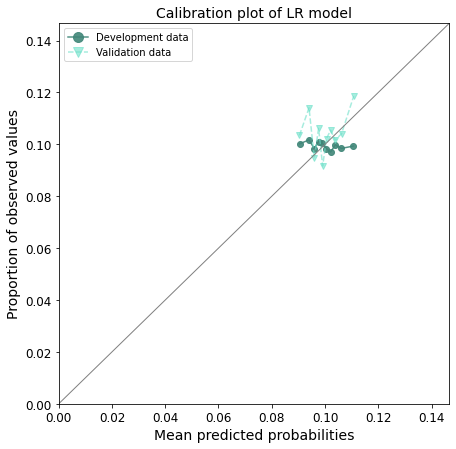

In [40]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_cough_no_abs_incdt, prob_pred_cough_no_abs_incdt_bin = cox_build('cough', 'incdt', data_cough_incdt, data_cough_no_abs_incdt)
except:
    print("error_1: cox model did not converge or failed to finalise.")

# try:
#build rf and lr models with deciles as predictors
prob_pred_enc_lr_rf_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt = lr_rf_build_risk_deciles('cough', 'incdt_deciles', prob_pred_cough_no_abs_incdt)
#calibration plots of rf and lr with deciles
calibration_rf_lr('cough', 'incdt_deciles', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt)#, rf_pred_dev_incdt, rf_pred_val_incdt)
# except:
#     print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

# #make summary table of deciles
# make_summary_table_deciles('cough', 'incdt', prob_pred_enc_lr_rf_incdt)

# try:
#build rf and lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
prob_pred_enc_lr_rf_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt = lr_rf_build_risk_riskfactors('cough', 'incdt_riskfactors', prob_pred_cough_no_abs_incdt)
#calibration plots of rf and lr with risk factors
calibration_rf_lr('cough', 'incdt_riskfactors', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt)#, rf_pred_dev_incdt, rf_pred_val_incdt)
# except:
#     print("error_3: lr or rf model for risk factors did not converge or failed to finalise or their calibration plot failed.")

In [41]:
# alpha = 0.05
# #the coefficients of the regression model
# coefs = np.r_[[lr.intercept_], lr.coef_.T.tolist()]
# #build an auxiliary dataframe with the constant term in it
# X_aux = data_enc_dev_incdt_x.copy()
# X_aux.insert(0, 'const', 1)
# #degrees of freedom
# dof = -np.diff(X_aux.shape)[0]
# #Student's t-distribution table lookup
# t_val = stats.t.isf(alpha/2, dof)
# #MSE of the residuals
# mse = np.sum((data_enc_dev_incdt_y['ab_binary'].to_numpy() - lr.predict(data_enc_dev_incdt_x)) ** 2) / dof
# #inverse of the variance of the parameters
# var_params = np.diag(np.linalg.inv(X_aux.T.dot(X_aux)))
# #distance between lower and upper bound of CI
# gap = t_val * np.sqrt(mse * var_params)
# coef_ints = pd.DataFrame({'coef': coefs.ravel(), 'coef_lower': coefs.ravel() - gap, 'coef_upper': coefs.ravel() + gap})
# coef_ints

#### 5-2- prevalent

<lifelines.CoxPHFitter: fitted with 11339 total observations, 11263 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 11339
number of events observed = 76
   partial log-likelihood = -692.83
         time fit was run = 2023-08-04 16:29:57 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.09       1.09       0.35            -0.60             0.77                 0.55                 2.17
CCI_cat[T.medium]                0.22       1.24       0.37            -0.51             0.95                 0.60                 2.59
CCI_cat[T.high]                  0.10       1.10       0.46            -0.80             0.99                 0.45                 2.70
CCI_cat[T.very_high]             0.04       1.04       0.41            -0.76             0.84                 0.47                 2.31
age_cat[T.25_34]                -0.33       0.72       0.41            -1.15             0.48                 0.32                 1.62
age_cat[T.35_44]                -0.62       0.54       0.44            -1.49             0.25                 0.23                 1.28
age_cat[T.45_54]                -0.90       0.41       0.49            -1.86             0.06                 0.16                 1.06
age_cat[T.55_64]                 0.25       1.29       0.36            -0.45             0.95                 0.64                 2.59
age_cat[T.65_74]                -0.39       0.68       0.41            -1.21             0.42                 0.30                 1.52
age_cat[T.75_more]              -0.34       0.71       0.41            -1.15             0.47                 0.32                 1.60
antibacterial_brit              -0.10       0.90       0.09            -0.27             0.06                 0.76                 1.07
bmi_cat[T.obese]                -0.51       0.60       0.36            -1.21             0.19                 0.30                 1.21
bmi_cat[T.overweight]           -0.55       0.58       0.48            -1.48             0.38                 0.23                 1.46
bmi_cat[T.underweight]          -1.36       0.26       1.05            -3.42             0.70                 0.03                 2.01
bmi_cat[T.unknown]              -0.59       0.55       0.40            -1.37             0.18                 0.25                 1.20
ethnicity[T.other]              -0.52       0.59       0.63            -1.75             0.71                 0.17                 2.03
ethnicity[T.unknown]            -0.34       0.71       0.45            -1.22             0.54                 0.29                 1.72
ethnicity[T.white]              -0.17       0.84       0.41            -0.97             0.62                 0.38                 1.86
flu_vaccine[T.yes]               0.02       1.02       0.37            -0.72             0.75                 0.49                 2.12
imd[T.medium]                   -0.90       0.41       0.45            -1.78            -0.02                 0.17                 0.98
imd[T.unaffluent]               -0.13       0.87       0.35            -0.83             0.56                 0.44                 1.75
imd[T.unknown]                  -0.78       0.46       0.75            -2.25             0.68                 0.11                 1.98
imd[T.very_affluent]             0.06       1.06       0.34            -0.60             0.73                 0.55                 2.07
imd[T.very_unaffluent]          -0.02       0.98       0.34            -0.70             0.65                 0.50                 1.92
region[T.east_midlands]          0.28       1.32       0.54         

13047


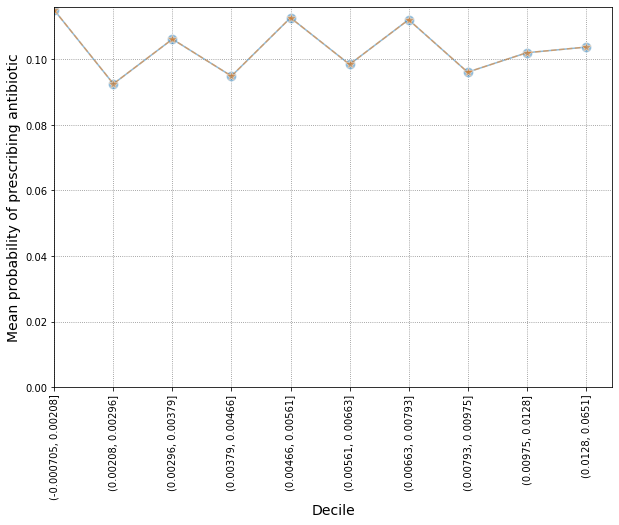


AUROC of LR for deciles with development and validation data: 0.52620 and 0.50637
LR summary:
                  covariate      coef  coef_lower_95%  coef_upper_95%  \
0  bins_(0.00208, 0.00296] -0.200449       -0.467953        0.067056   
1  bins_(0.00296, 0.00379] -0.112376       -0.374595        0.149843   
2  bins_(0.00379, 0.00466] -0.246909       -0.486575       -0.007243   
3  bins_(0.00466, 0.00561]  0.006455       -0.240999        0.253909   
4  bins_(0.00561, 0.00663] -0.229953       -0.494631        0.034725   
5  bins_(0.00663, 0.00793] -0.043319       -0.290678        0.204040   
6  bins_(0.00793, 0.00975] -0.224195       -0.460059        0.011669   
7   bins_(0.00975, 0.0128] -0.137271       -0.374823        0.100281   
8    bins_(0.0128, 0.0651] -0.151861       -0.405904        0.102182   

         or  or_lower_95%  or_upper_95%  
0  0.818363      0.626283      1.069355  
1  0.893708      0.687567      1.161652  
2  0.781212      0.614728      0.992783  
3  1.006476    

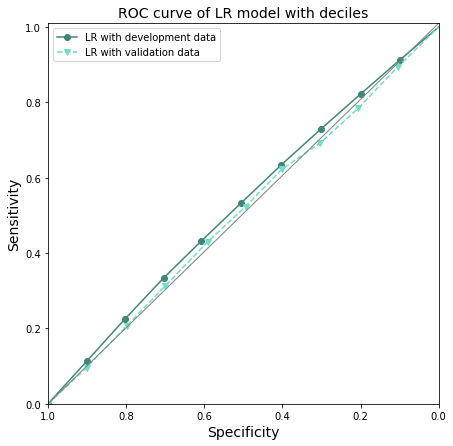

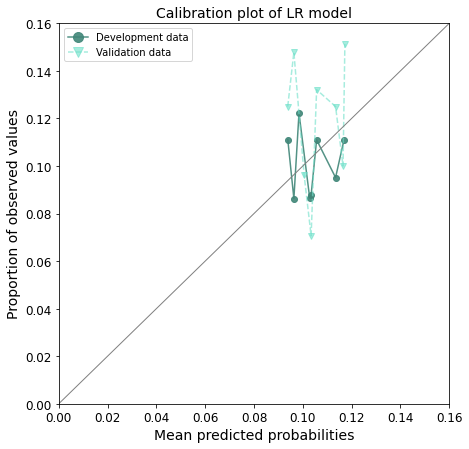


AUROC of LR for risk factors with development and validation data: 0.54650 and 0.49647
LR summary:
                       covariate      coef  coef_lower_95%  coef_upper_95%  \
0                 age_cat_25_34 -0.105352       -0.317832        0.107128   
1                 age_cat_35_44 -0.037389       -0.238300        0.163523   
2                 age_cat_45_54  0.031668       -0.197041        0.260378   
3                 age_cat_55_64 -0.075069       -0.272684        0.122545   
4                 age_cat_65_74  0.049601       -0.154830        0.254032   
5               age_cat_75_more -0.018978       -0.209197        0.171242   
6                      sex_male -0.032240       -0.145810        0.081331   
7                  CCI_cat_high  0.186349       -0.044233        0.416932   
8                   CCI_cat_low  0.078102       -0.105217        0.261421   
9                CCI_cat_medium -0.046242       -0.259490        0.167006   
10            CCI_cat_very_high  0.042058       -0.1

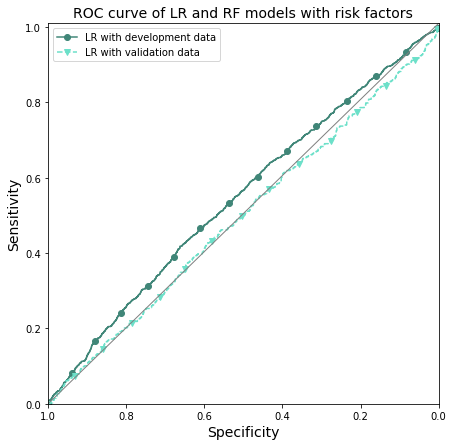

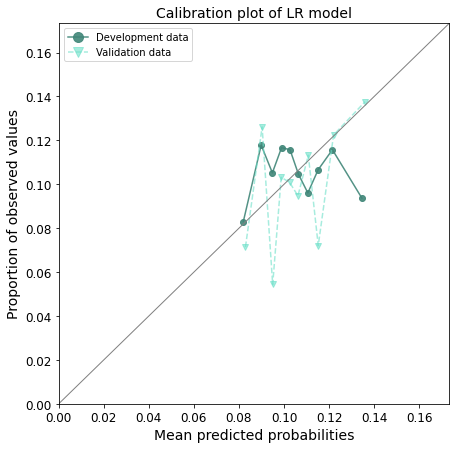

In [42]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_cough_no_abs_prevl, prob_pred_cough_no_abs_prevl_bin = cox_build('cough', 'prevl', data_cough_prevl, data_cough_no_abs_prevl)
except:
    print("error_1: cox model did not converge or failed to finalise.")

# try:
#build rf and lr models with deciles as predictors
prob_pred_enc_lr_rf_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl = lr_rf_build_risk_deciles('cough', 'prevl_deciles', prob_pred_cough_no_abs_prevl)
#calibration plots of rf and lr with deciles
calibration_rf_lr('cough', 'prevl_deciles', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl)#, rf_pred_dev_prevl, rf_pred_val_prevl)
# except:
#     print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

# #make summary table of deciles
# make_summary_table_deciles('cough', 'prevl', prob_pred_enc_lr_rf_prevl)

# try:
#build rf and lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
prob_pred_enc_lr_rf_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl = lr_rf_build_risk_riskfactors('cough', 'prevl_riskfactors', prob_pred_cough_no_abs_prevl)
#calibration plots of rf and lr with risk factors
calibration_rf_lr('cough', 'prevl_riskfactors', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl)#, rf_pred_dev_prevl, rf_pred_val_prevl)
# except:
#     print("error_3: lr or rf model for risk factors did not converge or failed to finalise or their calibration plot failed.")

#### 5-3- stratification by time period
#### 5-3-1- incident

<lifelines.CoxPHFitter: fitted with 28791 total observations, 28619 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 28791
number of events observed = 172
   partial log-likelihood = -1747.25
         time fit was run = 2023-08-04 16:31:13 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.04       0.96       0.23            -0.50             0.42                 0.61                 1.52
CCI_cat[T.medium]                0.09       1.10       0.25            -0.40             0.59                 0.67                 1.80
CCI_cat[T.high]                  0.02       1.02       0.31            -0.59             0.63                 0.56                 1.87
CCI_cat[T.very_high]             0.23       1.26       0.26            -0.27             0.74                 0.76                 2.09
age_cat[T.25_34]                -0.47       0.62       0.27            -0.99             0.05                 0.37                 1.05
age_cat[T.35_44]                -0.52       0.60       0.27            -1.04             0.01                 0.35                 1.01
age_cat[T.45_54]                -0.59       0.56       0.27            -1.12            -0.05                 0.33                 0.95
age_cat[T.55_64]                -0.63       0.53       0.28            -1.18            -0.09                 0.31                 0.91
age_cat[T.65_74]                -0.37       0.69       0.26            -0.88             0.13                 0.41                 1.14
age_cat[T.75_more]              -0.43       0.65       0.26            -0.94             0.09                 0.39                 1.09
antibacterial_brit              -0.00       1.00       0.05            -0.11             0.10                 0.90                 1.11
bmi_cat[T.obese]                -0.03       0.97       0.27            -0.56             0.50                 0.57                 1.64
bmi_cat[T.overweight]           -0.11       0.89       0.34            -0.78             0.55                 0.46                 1.74
bmi_cat[T.underweight]          -0.06       0.94       0.48            -1.00             0.88                 0.37                 2.41
bmi_cat[T.unknown]              -0.34       0.71       0.30            -0.93             0.25                 0.39                 1.29
ethnicity[T.other]               0.38       1.46       0.43            -0.47             1.23                 0.62                 3.42
ethnicity[T.unknown]             0.38       1.46       0.37            -0.34             1.09                 0.71                 2.98
ethnicity[T.white]               0.40       1.49       0.35            -0.28             1.08                 0.75                 2.94
flu_vaccine[T.yes]              -0.25       0.78       0.28            -0.80             0.30                 0.45                 1.34
imd[T.medium]                    0.23       1.26       0.26            -0.29             0.74                 0.75                 2.10
imd[T.unaffluent]                0.06       1.06       0.27            -0.48             0.60                 0.62                 1.82
imd[T.unknown]                   0.46       1.58       0.37            -0.27             1.19                 0.76                 3.27
imd[T.very_affluent]             0.48       1.61       0.25            -0.01             0.97                 0.99                 2.63
imd[T.very_unaffluent]           0.22       1.25       0.26            -0.30             0.73                 0.74                 2.08
region[T.east_midlands]         -0.21       0.81       0.37       

13044


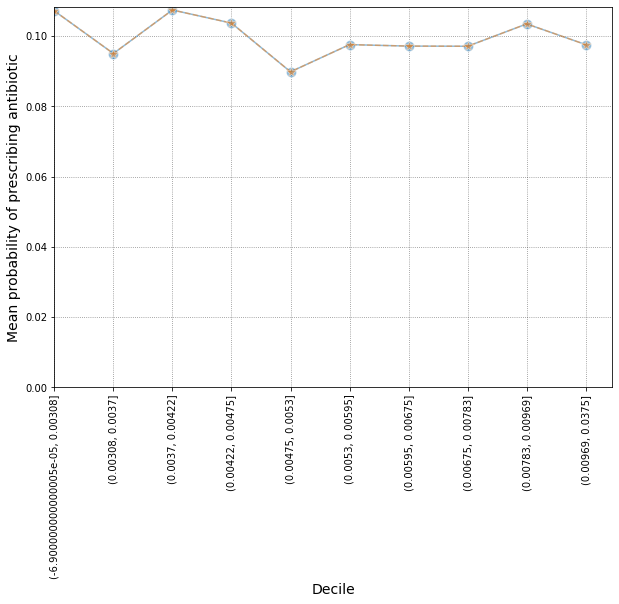


AUROC of LR for deciles with development and validation data: 0.52161 and 0.49798
LR summary:
                  covariate      coef  coef_lower_95%  coef_upper_95%  \
0   bins_(0.00308, 0.0037] -0.167290       -0.320094       -0.014487   
1   bins_(0.0037, 0.00422] -0.073523       -0.244293        0.097248   
2  bins_(0.00422, 0.00475] -0.007124       -0.153948        0.139701   
3   bins_(0.00475, 0.0053] -0.270667       -0.421474       -0.119860   
4   bins_(0.0053, 0.00595] -0.085729       -0.238647        0.067188   
5  bins_(0.00595, 0.00675] -0.151871       -0.298692       -0.005049   
6  bins_(0.00675, 0.00783] -0.149600       -0.293437       -0.005762   
7  bins_(0.00783, 0.00969] -0.025133       -0.168179        0.117914   
8   bins_(0.00969, 0.0375] -0.083431       -0.237725        0.070863   

         or  or_lower_95%  or_upper_95%  
0  0.845954      0.726081      0.985617  
1  0.929115      0.783258      1.102134  
2  0.992902      0.857316      1.149930  
3  0.762870    

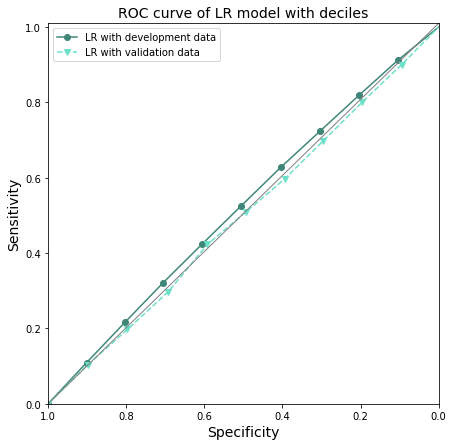

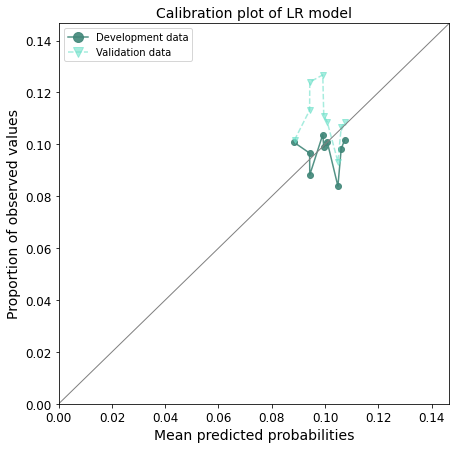

In [43]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_cough_no_abs_incdt_prepandemic, prob_pred_cough_no_abs_incdt_prepandemic_bin = cox_build('cough', 'incdt_prepandemic', data_cough_incdt_prepandemic, data_cough_no_abs_incdt_prepandemic)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_incdt_prepandemic, data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic = lr_rf_build_risk_deciles('cough', 'incdt_prepandemic_deciles', prob_pred_cough_no_abs_incdt_prepandemic)
    #calibration plots of rf and lr
    calibration_rf_lr('cough', 'incdt_prepandemic', data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic)#, rf_pred_dev_incdt_prepandemic, rf_pred_val_incdt_prepandemic)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 26022 total observations, 25863 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 26022
number of events observed = 159
   partial log-likelihood = -1600.32
         time fit was run = 2023-08-04 16:32:00 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.06       1.06       0.24            -0.41             0.52                 0.66                 1.68
CCI_cat[T.medium]                0.11       1.11       0.26            -0.40             0.62                 0.67                 1.85
CCI_cat[T.high]                 -0.22       0.80       0.34            -0.89             0.44                 0.41                 1.56
CCI_cat[T.very_high]             0.05       1.05       0.27            -0.49             0.59                 0.61                 1.80
age_cat[T.25_34]                -0.08       0.92       0.32            -0.71             0.55                 0.49                 1.73
age_cat[T.35_44]                 0.32       1.38       0.29            -0.25             0.90                 0.78                 2.45
age_cat[T.45_54]                 0.40       1.50       0.29            -0.16             0.97                 0.85                 2.64
age_cat[T.55_64]                -0.26       0.77       0.34            -0.92             0.39                 0.40                 1.48
age_cat[T.65_74]                -0.01       0.99       0.32            -0.63             0.61                 0.53                 1.84
age_cat[T.75_more]               0.25       1.28       0.30            -0.34             0.83                 0.71                 2.29
antibacterial_brit               0.02       1.03       0.06            -0.08             0.13                 0.92                 1.14
bmi_cat[T.obese]                 0.17       1.19       0.31            -0.43             0.78                 0.65                 2.18
bmi_cat[T.overweight]            0.30       1.36       0.36            -0.41             1.01                 0.67                 2.76
bmi_cat[T.underweight]          -0.82       0.44       0.76            -2.32             0.68                 0.10                 1.97
bmi_cat[T.unknown]               0.03       1.03       0.33            -0.62             0.68                 0.54                 1.98
ethnicity[T.other]              -0.19       0.83       0.49            -1.14             0.77                 0.32                 2.15
ethnicity[T.unknown]             0.10       1.10       0.37            -0.63             0.83                 0.53                 2.30
ethnicity[T.white]               0.35       1.41       0.35            -0.33             1.03                 0.72                 2.79
flu_vaccine[T.yes]              -0.07       0.93       0.27            -0.60             0.46                 0.55                 1.59
imd[T.medium]                   -0.04       0.96       0.24            -0.52             0.44                 0.59                 1.55
imd[T.unaffluent]               -0.26       0.77       0.26            -0.76             0.25                 0.47                 1.28
imd[T.unknown]                  -0.09       0.91       0.39            -0.87             0.68                 0.42                 1.97
imd[T.very_affluent]            -0.09       0.91       0.25            -0.58             0.39                 0.56                 1.48
imd[T.very_unaffluent]          -0.33       0.72       0.26            -0.85             0.19                 0.43                 1.20
region[T.east_midlands]         -0.14       0.87       0.34       

13054


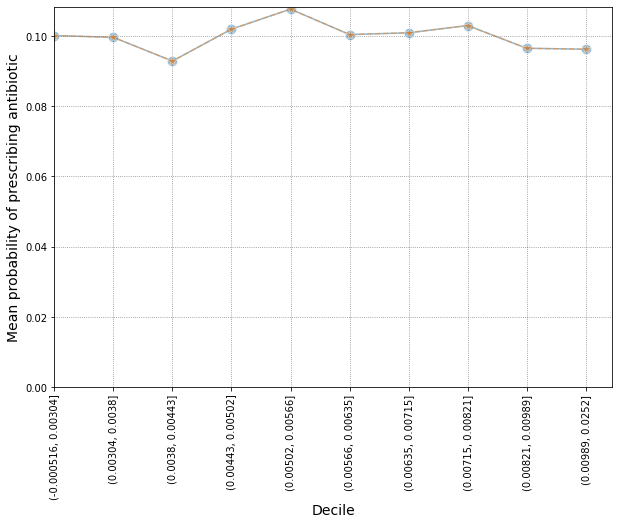


AUROC of LR for deciles with development and validation data: 0.51222 and 0.50892
LR summary:
                  covariate      coef  coef_lower_95%  coef_upper_95%  \
0   bins_(0.00304, 0.0038] -0.018184       -0.173117        0.136748   
1   bins_(0.0038, 0.00443] -0.146105       -0.318710        0.026499   
2  bins_(0.00443, 0.00502] -0.009652       -0.165121        0.145817   
3  bins_(0.00502, 0.00566]  0.042574       -0.105967        0.191115   
4  bins_(0.00566, 0.00635] -0.011758       -0.181162        0.157645   
5  bins_(0.00635, 0.00715]  0.018401       -0.141943        0.178744   
6  bins_(0.00715, 0.00821]  0.021269       -0.144981        0.187518   
7  bins_(0.00821, 0.00989] -0.022740       -0.203607        0.158127   
8   bins_(0.00989, 0.0252] -0.090569       -0.246975        0.065837   

         or  or_lower_95%  or_upper_95%  
0  0.981980      0.841039      1.146539  
1  0.864067      0.727086      1.026854  
2  0.990395      0.847791      1.156985  
3  1.043493    

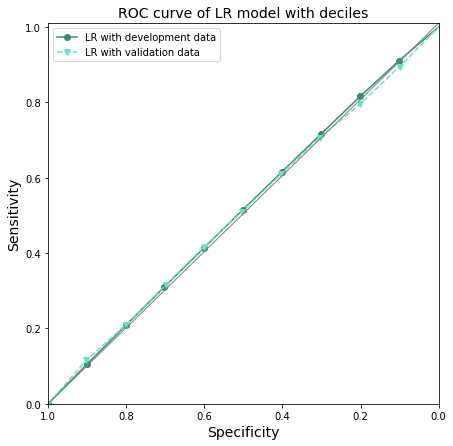

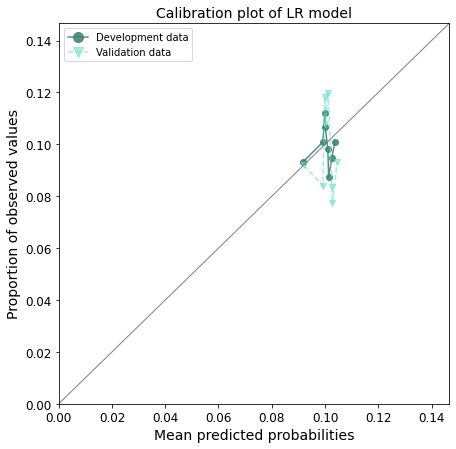

In [44]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_cough_no_abs_incdt_during_pandemic, prob_pred_cough_no_abs_incdt_during_pandemic_bin = cox_build('cough', 'incdt_during_pandemic', data_cough_incdt_during_pandemic, data_cough_no_abs_incdt_during_pandemic)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_incdt_during_pandemic, data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic = lr_rf_build_risk_deciles('cough', 'incdt_during_pandemic_deciles', prob_pred_cough_no_abs_incdt_during_pandemic)
    #calibration plots of rf and lr
    calibration_rf_lr('cough', 'incdt_during_pandemic', data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic)#, rf_pred_dev_incdt_during_pandemic, rf_pred_val_incdt_during_pandemic)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 47928 total observations, 47584 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 47928
number of events observed = 344
   partial log-likelihood = -3693.07
         time fit was run = 2023-08-04 16:32:21 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.06       0.94       0.16            -0.38             0.25                 0.68                 1.29
CCI_cat[T.medium]                0.05       1.05       0.18            -0.29             0.40                 0.75                 1.49
CCI_cat[T.high]                  0.12       1.12       0.20            -0.28             0.52                 0.75                 1.68
CCI_cat[T.very_high]             0.01       1.01       0.19            -0.36             0.37                 0.70                 1.45
age_cat[T.25_34]                 0.04       1.04       0.21            -0.37             0.45                 0.69                 1.56
age_cat[T.35_44]                 0.16       1.17       0.20            -0.24             0.55                 0.79                 1.74
age_cat[T.45_54]                 0.22       1.25       0.20            -0.17             0.62                 0.84                 1.85
age_cat[T.55_64]                -0.04       0.96       0.21            -0.46             0.37                 0.63                 1.45
age_cat[T.65_74]                 0.13       1.14       0.20            -0.27             0.53                 0.76                 1.70
age_cat[T.75_more]               0.10       1.11       0.21            -0.30             0.51                 0.74                 1.67
antibacterial_brit               0.03       1.03       0.04            -0.04             0.10                 0.96                 1.11
bmi_cat[T.obese]                 0.15       1.16       0.22            -0.27             0.58                 0.76                 1.78
bmi_cat[T.overweight]            0.13       1.14       0.26            -0.38             0.64                 0.69                 1.90
bmi_cat[T.underweight]          -0.09       0.91       0.39            -0.86             0.67                 0.42                 1.96
bmi_cat[T.unknown]               0.20       1.23       0.23            -0.24             0.65                 0.78                 1.92
ethnicity[T.other]               0.26       1.30       0.27            -0.26             0.79                 0.77                 2.21
ethnicity[T.unknown]            -0.10       0.90       0.23            -0.55             0.35                 0.57                 1.42
ethnicity[T.white]               0.07       1.07       0.21            -0.34             0.49                 0.71                 1.63
flu_vaccine[T.yes]              -0.04       0.96       0.18            -0.40             0.32                 0.67                 1.37
imd[T.medium]                    0.11       1.12       0.18            -0.23             0.46                 0.79                 1.59
imd[T.unaffluent]                0.08       1.09       0.18            -0.26             0.43                 0.77                 1.54
imd[T.unknown]                   0.38       1.46       0.24            -0.10             0.86                 0.90                 2.36
imd[T.very_affluent]             0.04       1.04       0.18            -0.31             0.39                 0.73                 1.48
imd[T.very_unaffluent]          -0.02       0.98       0.18            -0.37             0.34                 0.69                 1.40
region[T.east_midlands]         -0.12       0.89       0.23       

13036


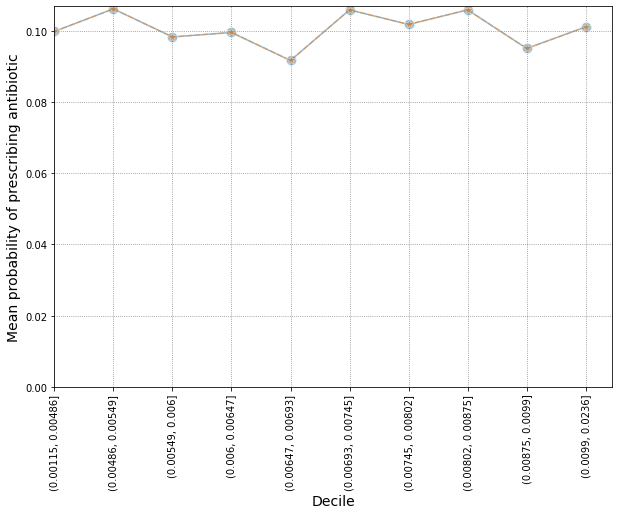


AUROC of LR for deciles with development and validation data: 0.51201 and 0.51428
LR summary:
                  covariate      coef  coef_lower_95%  coef_upper_95%  \
0  bins_(0.00486, 0.00549]  0.075949       -0.049542        0.201441   
1    bins_(0.00549, 0.006] -0.039915       -0.177376        0.097545   
2    bins_(0.006, 0.00647]  0.014341       -0.110788        0.139471   
3  bins_(0.00647, 0.00693] -0.018587       -0.132350        0.095176   
4  bins_(0.00693, 0.00745]  0.063619       -0.055979        0.183217   
5  bins_(0.00745, 0.00802]  0.010501       -0.113712        0.134714   
6  bins_(0.00802, 0.00875]  0.058013       -0.062021        0.178046   
7   bins_(0.00875, 0.0099] -0.051676       -0.182091        0.078738   
8    bins_(0.0099, 0.0236]  0.016026       -0.101964        0.134016   

         or  or_lower_95%  or_upper_95%  
0  1.078908      0.951665      1.223164  
1  0.960871      0.837465      1.102461  
2  1.014445      0.895128      1.149666  
3  0.981585    

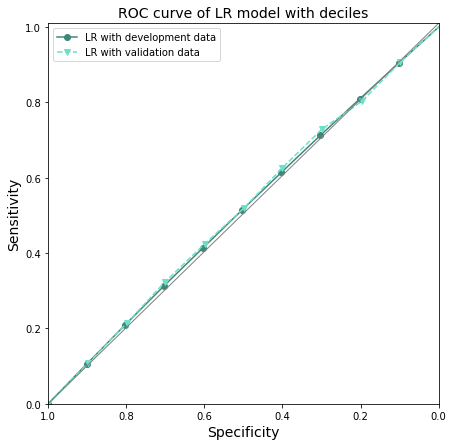

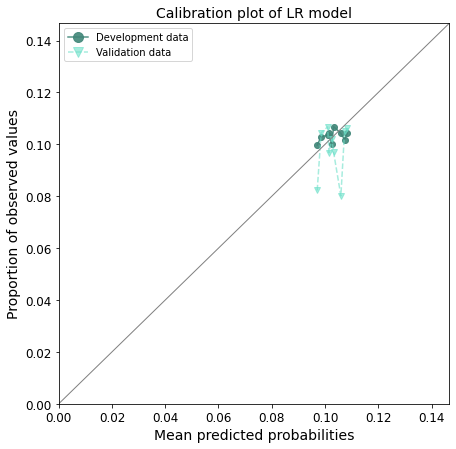

In [45]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_cough_no_abs_incdt_post_2nd_lockdown, prob_pred_cough_no_abs_incdt_post_2nd_lockdown_bin = cox_build('cough', 'incdt_post_2nd_lockdown', data_cough_incdt_post_2nd_lockdown, data_cough_no_abs_incdt_post_2nd_lockdown)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_incdt_post_2nd_lockdown, data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown = lr_rf_build_risk_deciles('cough', 'incdt_post_2nd_lockdown_deciles', prob_pred_cough_no_abs_incdt_post_2nd_lockdown)
    #calibration plots of rf and lr
    calibration_rf_lr('cough', 'incdt_post_2nd_lockdown', data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown)#, rf_pred_dev_incdt_post_2nd_lockdown, rf_pred_val_incdt_post_2nd_lockdown)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

#### 5-3-2- prevalent

<lifelines.CoxPHFitter: fitted with 3129 total observations, 3118 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 3129
number of events observed = 11
   partial log-likelihood = -69.80
         time fit was run = 2023-08-04 16:32:46 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.17       1.18       0.75            -1.30             1.64                 0.27                 5.15
CCI_cat[T.medium]              -18.73       0.00    6005.81        -11789.89         11752.43                 0.00                  inf
CCI_cat[T.high]                 -0.38       0.68       1.19            -2.72             1.96                 0.07                 7.09
CCI_cat[T.very_high]            -1.04       0.35       1.19            -3.37             1.30                 0.03                 3.66
age_cat[T.25_34]                 0.50       1.65       0.96            -1.38             2.38                 0.25                10.83
age_cat[T.35_44]                -0.52       0.60       1.26            -2.99             1.95                 0.05                 7.03
age_cat[T.45_54]                 0.50       1.66       1.03            -1.52             2.53                 0.22                12.56
age_cat[T.55_64]                -0.07       0.93       1.04            -2.10             1.96                 0.12                 7.12
age_cat[T.65_74]               -18.13       0.00    6931.69        -13603.99         13567.74                 0.00                  inf
age_cat[T.75_more]              -0.26       0.77       1.25            -2.72             2.20                 0.07                 9.04
antibacterial_brit               0.04       1.04       0.22            -0.39             0.47                 0.68                 1.60
bmi_cat[T.obese]                -1.18       0.31       0.90            -2.96             0.59                 0.05                 1.80
bmi_cat[T.overweight]           -0.50       0.60       1.05            -2.56             1.55                 0.08                 4.71
bmi_cat[T.underweight]           0.60       1.82       1.30            -1.94             3.14                 0.14                23.15
bmi_cat[T.unknown]              -0.92       0.40       1.06            -2.99             1.15                 0.05                 3.15
ethnicity[T.other]             -18.35       0.00    9520.03        -18677.26         18640.56                 0.00                  inf
ethnicity[T.unknown]             0.03       1.03       1.20            -2.32             2.38                 0.10                10.81
ethnicity[T.white]               0.08       1.08       1.10            -2.08             2.24                 0.12                 9.43
flu_vaccine[T.yes]             -18.18       0.00    7413.30        -14547.98         14511.61                 0.00                  inf
imd[T.medium]                   -0.57       0.56       1.25            -3.03             1.89                 0.05                 6.61
imd[T.unaffluent]                0.52       1.68       0.94            -1.33             2.36                 0.26                10.64
imd[T.unknown]                 -18.15       0.00   11179.50        -21929.57         21893.28                 0.00                  inf
imd[T.very_affluent]             0.22       1.25       1.02            -1.78             2.23                 0.17                 9.29
imd[T.very_unaffluent]           0.25       1.29       0.94            -1.59             2.10                 0.20                 8.15
region[T.east_midlands]        -18.97       0.00    8921.87        -1750

13180


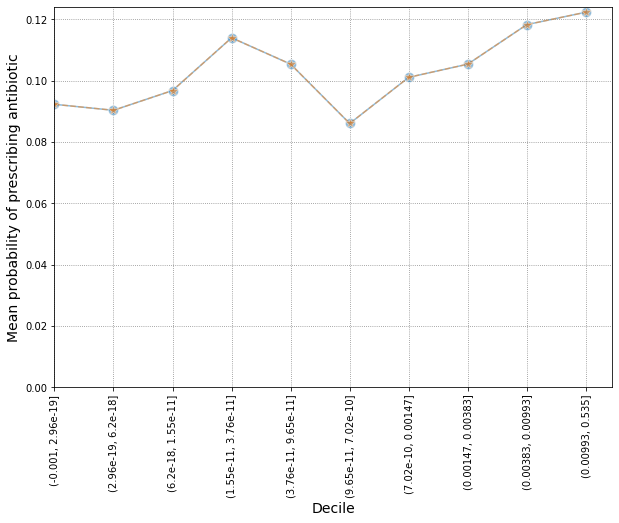


AUROC of LR for deciles with development and validation data: 0.54333 and 0.50679
LR summary:
                    covariate      coef  coef_lower_95%  coef_upper_95%  \
0    bins_(0.00147, 0.00383]  0.067043       -0.278997        0.413083   
1    bins_(0.00383, 0.00993]  0.307149       -0.141271        0.755568   
2      bins_(0.00993, 0.535]  0.334876       -0.040957        0.710709   
3  bins_(1.55e-11, 3.76e-11]  0.208791       -0.266597        0.684179   
4   bins_(2.96e-19, 6.2e-18]  0.002457       -0.456718        0.461632   
5  bins_(3.76e-11, 9.65e-11]  0.029143       -0.428393        0.486679   
6   bins_(6.2e-18, 1.55e-11] -0.008766       -0.427438        0.409906   
7   bins_(7.02e-10, 0.00147]  0.159667       -0.290645        0.609979   
8  bins_(9.65e-11, 7.02e-10] -0.176354       -0.589774        0.237066   

         or  or_lower_95%  or_upper_95%  
0  1.069342      0.756543      1.511470  
1  1.359543      0.868254      2.128821  
2  1.397767      0.959870      2.0354

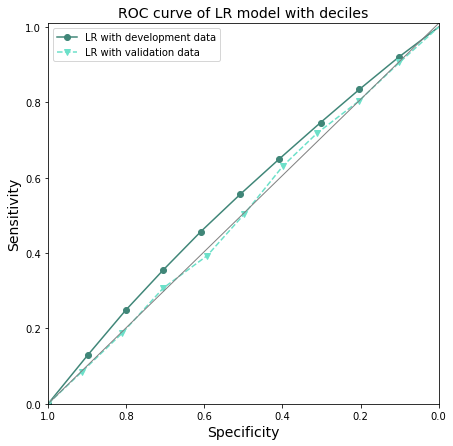

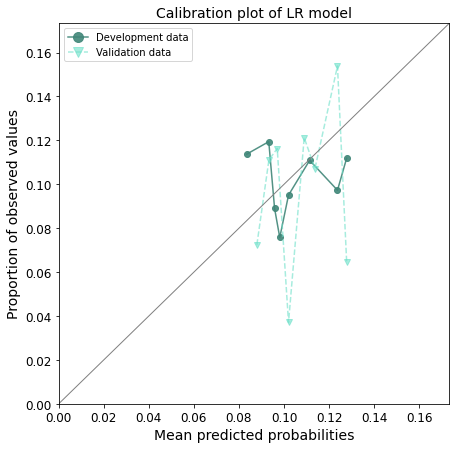

In [46]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_cough_no_abs_prevl_prepandemic, prob_pred_cough_no_abs_prevl_prepandemic_bin = cox_build('cough', 'prevl_prepandemic', data_cough_prevl_prepandemic, data_cough_no_abs_prevl_prepandemic)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_prevl_prepandemic, data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic = lr_rf_build_risk_deciles('cough', 'prevl_prepandemic_deciles', prob_pred_cough_no_abs_prevl_prepandemic)
    #calibration plots of rf and lr
    calibration_rf_lr('cough', 'prevl_prepandemic', data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic)#, rf_pred_dev_prevl_prepandemic, rf_pred_val_prevl_prepandemic)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 2861 total observations, 2844 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 2861
number of events observed = 17
   partial log-likelihood = -115.04
         time fit was run = 2023-08-04 16:33:03 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.73       0.48       0.83            -2.36             0.89                 0.09                 2.44
CCI_cat[T.medium]                0.51       1.67       0.72            -0.91             1.93                 0.40                 6.91
CCI_cat[T.high]                 -0.58       0.56       1.17            -2.88             1.71                 0.06                 5.55
CCI_cat[T.very_high]             0.33       1.40       0.79            -1.22             1.88                 0.30                 6.57
age_cat[T.25_34]                -0.95       0.39       0.89            -2.69             0.79                 0.07                 2.21
age_cat[T.35_44]                -0.61       0.55       0.80            -2.18             0.97                 0.11                 2.64
age_cat[T.45_54]                -0.31       0.73       0.78            -1.84             1.21                 0.16                 3.36
age_cat[T.55_64]                -0.30       0.74       0.78            -1.84             1.23                 0.16                 3.42
age_cat[T.65_74]                -0.55       0.58       0.89            -2.29             1.19                 0.10                 3.28
age_cat[T.75_more]             -18.45       0.00    4763.50         -9354.73          9317.83                 0.00                  inf
antibacterial_brit              -0.34       0.71       0.22            -0.76             0.09                 0.47                 1.09
bmi_cat[T.obese]                 0.16       1.18       1.07            -1.94             2.26                 0.14                 9.59
bmi_cat[T.overweight]          -17.54       0.00    5042.40         -9900.46          9865.38                 0.00                  inf
bmi_cat[T.underweight]           0.59       1.80       1.47            -2.29             3.46                 0.10                31.79
bmi_cat[T.unknown]               0.61       1.83       1.11            -1.56             2.77                 0.21                16.02
ethnicity[T.other]              18.38   9.63e+07    6657.88        -13030.81         13067.58                 0.00                  inf
ethnicity[T.unknown]            16.35   1.26e+07    6657.88        -13032.85         13065.55                 0.00                  inf
ethnicity[T.white]              18.14   7.58e+07    6657.88        -13031.05         13067.34                 0.00                  inf
flu_vaccine[T.yes]               0.12       1.13       0.78            -1.40             1.65                 0.25                 5.19
imd[T.medium]                   -0.59       0.56       0.74            -2.05             0.87                 0.13                 2.40
imd[T.unaffluent]               -0.70       0.49       0.75            -2.18             0.77                 0.11                 2.15
imd[T.unknown]                 -18.17       0.00    7701.56        -15112.95         15076.62                 0.00                  inf
imd[T.very_affluent]            -0.42       0.66       0.75            -1.89             1.04                 0.15                 2.84
imd[T.very_unaffluent]          -0.70       0.50       0.76            -2.19             0.80                 0.11                 2.23
region[T.east_midlands]         -0.05       0.95       1.43            

13141


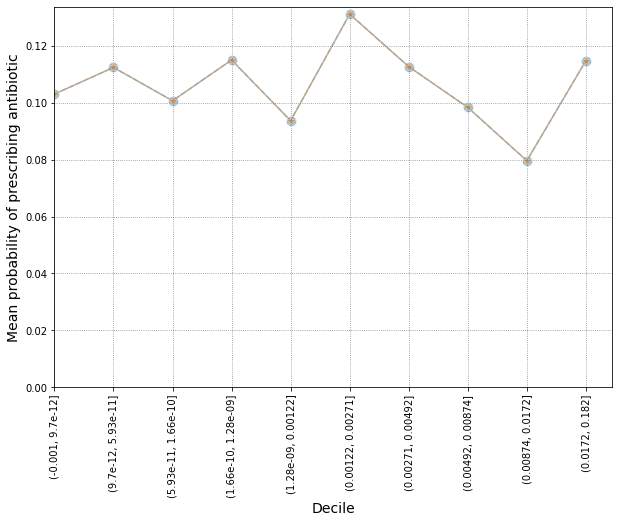


AUROC of LR for deciles with development and validation data: 0.55175 and 0.47469
LR summary:
                    covariate      coef  coef_lower_95%  coef_upper_95%  \
0    bins_(0.00122, 0.00271]  0.302824       -0.081871        0.687518   
1    bins_(0.00271, 0.00492]  0.038897       -0.402274        0.480067   
2    bins_(0.00492, 0.00874] -0.195381       -0.638446        0.247683   
3     bins_(0.00874, 0.0172] -0.144918       -0.615039        0.325204   
4       bins_(0.0172, 0.182]  0.081614       -0.326544        0.489772   
5   bins_(1.28e-09, 0.00122] -0.181220       -0.668182        0.305741   
6  bins_(1.66e-10, 1.28e-09]  0.290400       -0.080334        0.661134   
7  bins_(5.93e-11, 1.66e-10]  0.143149       -0.283991        0.570289   
8   bins_(9.7e-12, 5.93e-11]  0.264589       -0.113138        0.642316   

         or  or_lower_95%  or_upper_95%  
0  1.353676      0.921391      1.988774  
1  1.039663      0.668797      1.616183  
2  0.822521      0.528113      1.2810

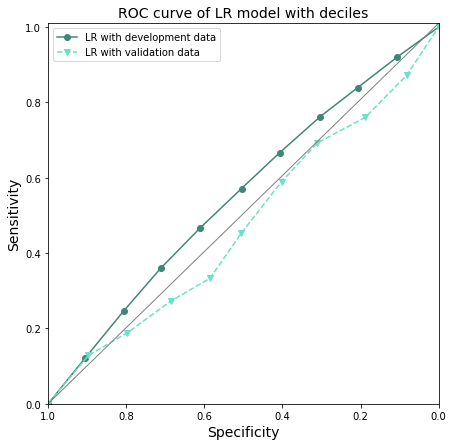

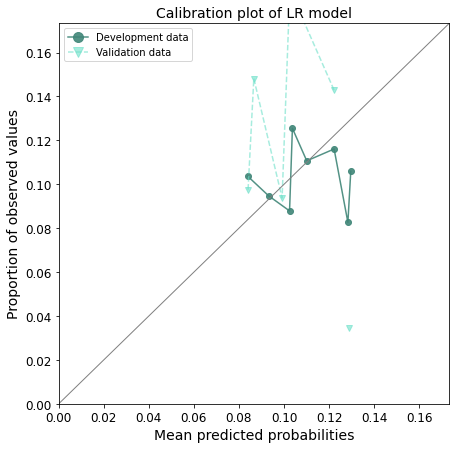

In [47]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_cough_no_abs_prevl_during_pandemic, prob_pred_cough_no_abs_prevl_during_pandemic_bin = cox_build('cough', 'prevl_during_pandemic', data_cough_prevl_during_pandemic, data_cough_no_abs_prevl_during_pandemic)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_prevl_during_pandemic, data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic = lr_rf_build_risk_deciles('cough', 'prevl_during_pandemic_deciles', prob_pred_cough_no_abs_prevl_during_pandemic)
    #calibration plots of rf and lr
    calibration_rf_lr('cough', 'prevl_during_pandemic', data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic)#, rf_pred_dev_prevl_during_pandemic, rf_pred_val_prevl_during_pandemic)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 5349 total observations, 5307 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 5349
number of events observed = 42
   partial log-likelihood = -337.99
         time fit was run = 2023-08-04 16:33:20 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.10       1.11       0.50            -0.87             1.08                 0.42                 2.93
CCI_cat[T.medium]               -0.12       0.89       0.58            -1.25             1.02                 0.29                 2.77
CCI_cat[T.high]                  0.90       2.46       0.53            -0.14             1.94                 0.87                 6.98
CCI_cat[T.very_high]             0.36       1.44       0.54            -0.70             1.43                 0.50                 4.17
age_cat[T.25_34]                -1.30       0.27       0.79            -2.86             0.25                 0.06                 1.29
age_cat[T.35_44]                -0.14       0.87       0.52            -1.16             0.88                 0.31                 2.41
age_cat[T.45_54]                -0.96       0.38       0.68            -2.30             0.37                 0.10                 1.45
age_cat[T.55_64]                 0.06       1.06       0.51            -0.93             1.05                 0.39                 2.87
age_cat[T.65_74]                -0.21       0.81       0.52            -1.23             0.82                 0.29                 2.26
age_cat[T.75_more]              -0.17       0.85       0.52            -1.18             0.85                 0.31                 2.34
antibacterial_brit              -0.03       0.97       0.11            -0.24             0.19                 0.78                 1.21
bmi_cat[T.obese]                 0.10       1.10       0.54            -0.97             1.16                 0.38                 3.20
bmi_cat[T.overweight]           -0.53       0.59       0.77            -2.03             0.98                 0.13                 2.66
bmi_cat[T.underweight]          -0.30       0.74       1.13            -2.51             1.90                 0.08                 6.69
bmi_cat[T.unknown]              -0.38       0.68       0.62            -1.59             0.83                 0.20                 2.30
ethnicity[T.other]              -0.52       0.59       1.23            -2.93             1.88                 0.05                 6.57
ethnicity[T.unknown]             0.63       1.88       0.77            -0.87             2.13                 0.42                 8.44
ethnicity[T.white]               0.59       1.80       0.74            -0.86             2.03                 0.42                 7.62
flu_vaccine[T.yes]               0.39       1.48       0.45            -0.49             1.27                 0.61                 3.55
imd[T.medium]                   -1.18       0.31       0.80            -2.76             0.39                 0.06                 1.48
imd[T.unaffluent]                0.48       1.62       0.49            -0.47             1.43                 0.62                 4.19
imd[T.unknown]                 -16.71       0.00    3289.83         -6464.65          6431.23                 0.00                  inf
imd[T.very_affluent]             0.40       1.49       0.50            -0.57             1.37                 0.57                 3.94
imd[T.very_unaffluent]           0.65       1.91       0.48            -0.29             1.59                 0.75                 4.89
region[T.east_midlands]         -0.78       0.46       0.71            

13059


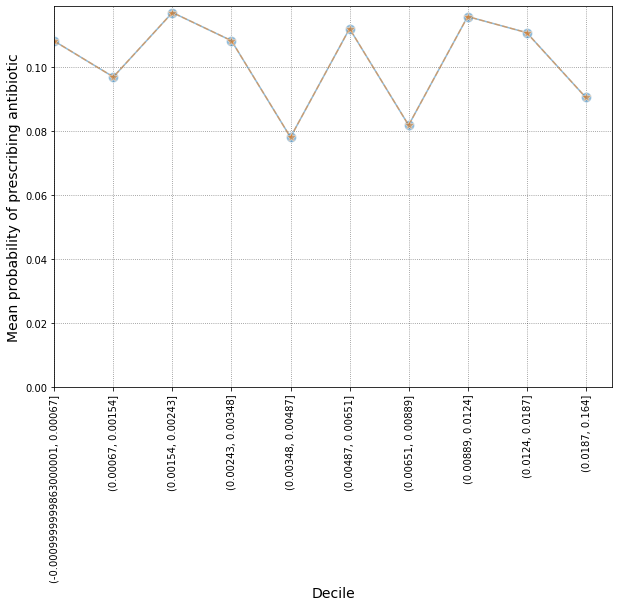


AUROC of LR for deciles with development and validation data: 0.54401 and 0.51684
LR summary:
                  covariate      coef  coef_lower_95%  coef_upper_95%  \
0  bins_(0.00067, 0.00154] -0.188693       -0.529105        0.151719   
1  bins_(0.00154, 0.00243]  0.056879       -0.281622        0.395380   
2  bins_(0.00243, 0.00348] -0.060531       -0.424094        0.303033   
3  bins_(0.00348, 0.00487] -0.415427       -0.826832       -0.004022   
4  bins_(0.00487, 0.00651] -0.018030       -0.367656        0.331597   
5  bins_(0.00651, 0.00889] -0.394987       -0.798151        0.008177   
6   bins_(0.00889, 0.0124] -0.120649       -0.499030        0.257731   
7    bins_(0.0124, 0.0187] -0.041300       -0.347654        0.265053   
8     bins_(0.0187, 0.164] -0.207107       -0.607017        0.192803   

         or  or_lower_95%  or_upper_95%  
0  0.828041      0.589132      1.163834  
1  1.058528      0.754559      1.484948  
2  0.941265      0.654362      1.353959  
3  0.660058    

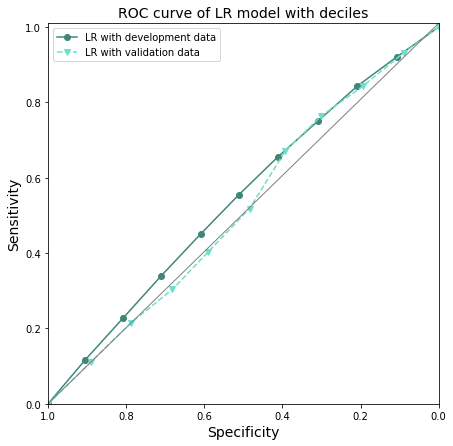

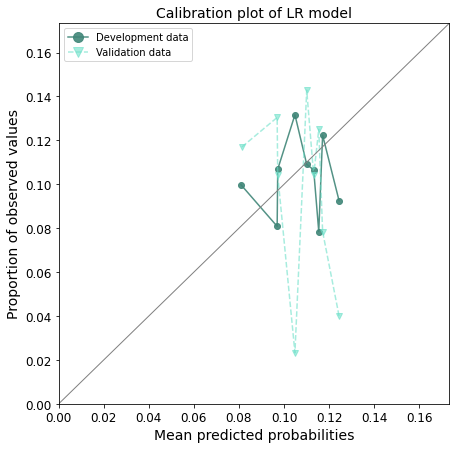

In [48]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_cough_no_abs_prevl_post_2nd_lockdown, prob_pred_cough_no_abs_prevl_post_2nd_lockdown_bin = cox_build('cough', 'prevl_post_2nd_lockdown', data_cough_prevl_post_2nd_lockdown, data_cough_no_abs_prevl_post_2nd_lockdown)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_prevl_post_2nd_lockdown, data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown = lr_rf_build_risk_deciles('cough', 'prevl_post_2nd_lockdown_deciles', prob_pred_cough_no_abs_prevl_post_2nd_lockdown)
    #calibration plots of rf and lr
    calibration_rf_lr('cough', 'prevl_post_2nd_lockdown', data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown)#, rf_pred_dev_prevl_post_2nd_lockdown, rf_pred_val_prevl_post_2nd_lockdown)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")